# San Francisco Restaurant Project

## Inspection Scores

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [57]:
raw_score_data = pd.read_csv('Restaurant_Scores_-_LIVES_Standard.csv')

In [58]:
raw_score_data.head()

,business_id,business_name,business_address,business_city,business_state,business_postal_code,business_latitude,business_longitude,business_location,business_phone_number,inspection_id,inspection_date,inspection_score,inspection_type,violation_id,violation_description,risk_category
0,1922,All stars Donuts,901 Clement St,San Francisco,CA,94118,37.782694,-122.468969,"(37.782694, -122.468969)",NaN,1922_20160225,02/25/2016 12:00:00 AM,86.0,Routine - Unscheduled,1922_20160225_103154,Unclean or degraded floors walls or ceilings,Low Risk
1,67448,Soo Fong Restaurant,3801 03rd St 370,San Francisco,CA,94124,37.741829,-122.388098,"(37.741829, -122.388098)",NaN,67448_20180507,05/07/2018 12:00:00 AM,92.0,Routine - Unscheduled,67448_20180507_103149,Wiping cloths not clean or properly stored or ...,Low Risk
2,1757,Dar Bar Pakistani/Indian Cusine,1412 Polk St,San Francisco,CA,94109,37.789784,-122.420455,"(37.789784, -122.420455)",NaN,1757_20170928,09/28/2017 12:00:00 AM,86.0,Routine - Unscheduled,1757_20170928_103131,Moderate risk vermin infestation,Moderate Risk
3,93022,Wise Sons Delicatessen,537 Octavia St,San Francisco,CA,94102,NaN,NaN,NaN,NaN,93022_20180907,09/07/2018 12:00:00 AM,92.0,Routine - Unscheduled,93022_20180907_103119,Inadequate and inaccessible handwashing facili...,Moderate Risk
4,4864,DRAGON CITY BAKERY & CAFE,2367 MISSION St,San Francisco,CA,94110,37.759174,-122.419066,"(37.759174, -122.419066)",1.415583e+10,4864_20161206,12/06/2016 12:00:00 AM,84.0,Routine - Unscheduled,4864_20161206_103157,Food safety certificate or food handler card n...,Low Risk


## Data Cleaning

In [114]:
#replace 0 lat and long with np.nan
raw_score_data['business_latitude'] = raw_score_data['business_latitude'].replace(0, np.NaN)
raw_score_data['business_longitude'] = raw_score_data['business_longitude'].replace(0, np.NaN)

#drop NaN values in the colums we require 
clean_data = raw_score_data.dropna(axis=0, subset=['business_latitude', 'business_longitude', 'business_name', 'inspection_score'])
#drop unneccesary columns
clean_data = clean_data.drop(['inspection_id', 'violation_id', 'business_phone_number', 'inspection_type', 'business_location', 'violation_description'], axis = 1)
#convert inspection date to datetime object
clean_data['inspection_date'] = pd.to_datetime(clean_data['inspection_date'])
#sort the data by date and keep only the most recent inspection instance for each business
clean_data = clean_data.sort_values('inspection_date')
clean_data = clean_data.drop_duplicates('business_id', keep = 'last')
clean_data.head()

,business_id,business_name,business_address,business_city,business_state,business_postal_code,business_latitude,business_longitude,inspection_date,inspection_score,risk_category
27309,7119,LO-COST MEAT MARKET #2,2918 24th St,San Francisco,CA,94110,37.752768,-122.410472,2016-02-17,77.0,Low Risk
8967,64319,Littlegreencyclo LLC,Off The Grid-Upper Haight,San Francisco,CA,NaN,37.777122,-122.419639,2016-02-19,100.0,NaN
26003,4372,CLUB PUERTORRIQUENO OF SF INC.,3249A MISSION St,San Francisco,CA,94110,37.744901,-122.420273,2016-02-26,100.0,NaN
23218,67606,Mayo & Mustard,75 Hawthorne,San Francisco,CA,94105,37.785144,-122.398383,2016-02-26,96.0,Low Risk
40620,5291,EL TONAYENSE CATERING TRUCK #2,3101 19th St,San Francisco,CA,94110,37.760583,-122.413239,2016-02-29,90.0,Low Risk


In [185]:
dropwords = ['mollie stone', 'chevron', 'shell' 'marriott', 'hilton', 'school', 'hotel', "church","cathedral","convention center", "mosque",
            "islamic","synagogue","jewish","museum","academy","temple","safeway","target","whole foods","gas","trader joe's",
            "market", "pharmacy", "cvs", "drug","hotel","marriot","westin","ritz"]

In [186]:
for word in dropwords: 
    droplist = list(clean_data[clean_data['business_name'].str.contains(word, case=False)].index)
    for i in droplist:
        clean_data = clean_data.drop(i)

In [199]:
clean_data.iloc[3]

business_id                                       5291
business_name           EL TONAYENSE CATERING TRUCK #2
business_address                          3101 19th St
business_city                            San Francisco
business_state                                      CA
business_postal_code                             94110
business_latitude                              37.7606
business_longitude                            -122.413
inspection_date                    2016-02-29 00:00:00
inspection_score                                    90
risk_category                                 Low Risk
Name: 40620, dtype: object

## Initial Exploratory Data Analysis

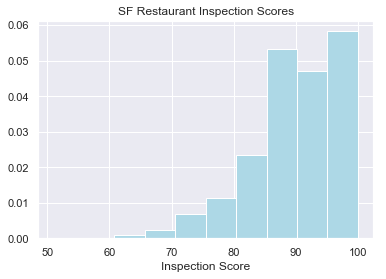

In [194]:
sns.set()
plt.hist(clean_data['inspection_score'], density=True, color ='lightblue' )
plt.title('SF Restaurant Inspection Scores')
plt.xlabel('Inspection Score')
plt.show()

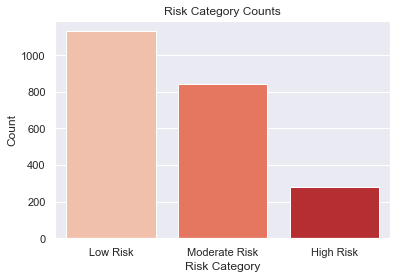

In [192]:
sns.countplot(clean_data['risk_category'], palette="Reds")
plt.xlabel("Risk Category")
plt.ylabel("Count")
plt.title("Risk Category Counts")
plt.show()

## Yelp Data Retrieval 

In [6]:
import requests #for querying the yelp api
import json #for api data handling 

In [7]:
#safely retrieve our API Key
file = open("APIKEY.txt", 'r')
API_KEY = file.read()
file.close()

In [201]:
def data_collector(dataframe, index, api_key):
    """Collects Data For a Griven Restaurant From Yelp"""
    #takes data frame and index as input. Outputs Dictionary with yelp information
    #will return 0 if failure
    #json and requests are neccessary

    #datafame col names must be in original formating
    #extract search information form data frame
    name = raw_score_data.iloc[index]['business_name']
    address = raw_score_data.iloc[index]['business_address']
    lat = raw_score_data.iloc[index]['business_latitude']
    long = raw_score_data.iloc[index]['business_longitude']


    url_match = "https://api.yelp.com/v3/businesses/matches"
    url_business = "https://api.yelp.com/v3/businesses/"

    #parameters to send api are fed int the querystring
    querystring = {"name":name,"city":"San%20Francisco","state":"CA","country":"US","address1":address,"latitude": lat,"longitude":long}
    payload = ""

    #API authorization is sent through the header
    headers = {
    'Authorization': "Bearer " + api_key,
    'cache-control': "no-cache",
    }

    #query yelp API using requests
    match_response = requests.request("GET", url_match, data=payload, headers=headers, params=querystring)
    match_dict = match_response.json()

    if match_response.status_code != 200:
        return 0
    if len(match_dict['businesses']) == 0:
        return 0

    business_id = match_dict['businesses'][0]['id']

    business_response = requests.request("GET", url_business + business_id, data=payload, headers=headers)

    if business_response.status_code != 200:
        return 0

    info = business_response.json()

    #return business information from yelp
    return info

In [320]:
yelp_data = clean_data
yelp_data['rating'] = np.NaN
yelp_data['price'] = np.NaN
yelp_data['review_count'] = np.NaN
yelp_data['open'] = np.NaN
yelp_data['close'] = np.NaN
yelp_data = yelp_data.reset_index()
yelp_data = yelp_data.drop('index', axis=1)
yelp_data.head()

,business_id,business_name,business_address,business_city,business_state,business_postal_code,business_latitude,business_longitude,inspection_date,inspection_score,risk_category,rating,price,review_count,open,close
0,64319,Littlegreencyclo LLC,Off The Grid-Upper Haight,San Francisco,CA,NaN,37.777122,-122.419639,2016-02-19,100.0,NaN,NaN,NaN,NaN,NaN,NaN
1,4372,CLUB PUERTORRIQUENO OF SF INC.,3249A MISSION St,San Francisco,CA,94110,37.744901,-122.420273,2016-02-26,100.0,NaN,NaN,NaN,NaN,NaN,NaN
2,67606,Mayo & Mustard,75 Hawthorne,San Francisco,CA,94105,37.785144,-122.398383,2016-02-26,96.0,Low Risk,NaN,NaN,NaN,NaN,NaN
3,5291,EL TONAYENSE CATERING TRUCK #2,3101 19th St,San Francisco,CA,94110,37.760583,-122.413239,2016-02-29,90.0,Low Risk,NaN,NaN,NaN,NaN,NaN
4,5437,Stanley's Steamers,NW Corner Post at Stockton St (N/W),San Francisco,CA,94108,37.791586,-122.408452,2016-03-02,100.0,NaN,NaN,NaN,NaN,NaN,NaN


In [322]:
yelplist = []
for index in yelp_data.index:
    d = data_collector(yelp_data, idx, API_KEY)
    yelplist.append(d)
    

In [324]:
with open('yelpdata', 'w') as fout:
    json.dump(yelplist, fout)

In [325]:
len(yelplist)

2518